In [1]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import torch
torch.cuda.empty_cache()
torch.manual_seed(42)

In [ ]:
from tqdm import tqdm


def create_chunks_batch_tokenization(texts, tokenizer, pre_seq_length=1000, train_seq_len=1024):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token
    chunks = []
    
    for text in tqdm(texts):
        sentences = text.split(".")  # Split text into sentences
        input_buffer = []
        token_count = 0

        # Batch tokenize sentences
        batch_tokens = tokenizer(
            sentences,
            return_tensors="pt",
            truncation=True,
            padding=True
        )["input_ids"]

        for tokens, sentence in zip(batch_tokens, sentences):
            current_token_length = (tokens != tokenizer.pad_token_id).sum().item()  # Count non-padding tokens

            # Skip sentences that are too long individually
            if current_token_length > pre_seq_length:
                print(f"Skipping sentence as it exceeds seq_length: {sentence[:50]}...")
                continue

            if token_count + current_token_length <= pre_seq_length:
                # Add the sentence if it fits
                input_buffer.append(sentence)
                token_count += current_token_length
            else:
                # Add the current chunk to the list and reset buffer
                if input_buffer:
                    chunks.append(" ".join(input_buffer))
                input_buffer = [sentence]
                token_count = current_token_length

        # Handle leftover sentences in the buffer
        if input_buffer:
            chunks.append(" ".join(input_buffer))

    # Validate all chunks and remove long ones
    idx = 0
    while idx < len(chunks):
        tokenized_chunk = tokenizer(chunks[idx])["input_ids"]
        if len(tokenized_chunk) > train_seq_len - 10:
            print(f"Error: Chunk {idx} is too long after processing ({len(tokenized_chunk)} tokens).")
            chunks.pop(idx)  # Remove the chunk and do not increment the index
        else:
            idx += 1  # Only increment if no removal happened


    return chunks

In [ ]:
from tqdm import tqdm


def create_ebae_ebar_chunks(texts, tokenizer, pre_seq_length=1000, train_seq_len=1024):
    """
    Creates chunks for EBAE and EBAR by separating prompts and next sentences.
    
    :param texts: List of texts to process.
    :param tokenizer: Tokenizer object for tokenizing the text.
    :param pre_seq_length: Maximum length of the prompt chunk before adding the next sentence.
    :param train_seq_len: Maximum sequence length for training.
    :return: Two lists: prompts (EBAE input) and next sentences (EBAR input).
    """
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token
    prompts = []
    next_sentences = []
    
    for text in tqdm(texts):
        sentences = text.split(".")  # Split text into sentences
        input_buffer = []
        token_count = 0

        # Batch tokenize sentences
        batch_tokens = tokenizer(
            sentences,
            return_tensors="pt",
            truncation=True,
            padding=True
        )["input_ids"]

        for i, (tokens, sentence) in enumerate(zip(batch_tokens, sentences)):
            current_token_length = (tokens != tokenizer.pad_token_id).sum().item()  # Count non-padding tokens

            # Skip sentences that are too long individually
            if current_token_length > pre_seq_length:
                print(f"Skipping sentence as it exceeds seq_length: {sentence[:50]}...")
                continue

            if token_count + current_token_length <= pre_seq_length:
                # Add the sentence if it fits
                input_buffer.append(sentence)
                token_count += current_token_length
            else:
                # Add the current chunk to the list and reset buffer
                if input_buffer and i < len(sentences) - 1:  # Ensure there's a next sentence
                    prompts.append(" ".join(input_buffer))
                    next_sentences.append(sentences[i])  # Use the next sentence for EBAR
                input_buffer = [sentence]
                token_count = current_token_length

        # Handle leftover sentences in the buffer
        if input_buffer and len(input_buffer) < len(sentences):
            prompts.append(" ".join(input_buffer))
            next_sentences.append(sentences[len(input_buffer)])  # Use the next available sentence

    # Validate all chunks and remove invalid pairs
    valid_prompts, valid_next_sentences = [], []
    for idx in range(len(prompts)):
        prompt_tokens = tokenizer(prompts[idx])["input_ids"]
        next_tokens = tokenizer(next_sentences[idx])["input_ids"]

        if len(prompt_tokens) <= train_seq_len - 10 and len(next_tokens) <= train_seq_len - 10:
            valid_prompts.append(prompts[idx])
            valid_next_sentences.append(next_sentences[idx])
        else:
            print(f"Error: Pair {idx} is too long after processing (prompt: {len(prompt_tokens)} tokens, next: {len(next_tokens)} tokens).")

    return valid_prompts, valid_next_sentences


In [4]:
# # Wrapper function for parallel processing
# def process_texts_in_parallel(texts_subset, tokenizer, seq_length):
#     return create_chunks_batch_tokenization(texts_subset, tokenizer, seq_length)

In [5]:
# import math
# from multiprocessing import Pool

# # Main parallelized chunking function
# def create_chunks_parallel(texts, tokenizer, seq_length=1024, num_workers=8):
#     # Divide the dataset into chunks for parallel processing
#     chunk_size = math.ceil(len(texts) / num_workers)
#     text_chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]

#     # Use multiprocessing Pool to parallelize the work
#     with Pool(processes=num_workers) as pool:
#         # Use tqdm to track progress
#         results = list(
#             tqdm(
#                 pool.starmap(process_texts_in_parallel, [(chunk, tokenizer, seq_length) for chunk in text_chunks]),
#                 total=len(text_chunks),
#                 desc="Processing Chunks in Parallel"
#             )
#         )

#     # Flatten the list of results
#     all_chunks = [chunk for result in results for chunk in result]
#     return all_chunks

In [6]:
# from datasets import load_dataset

# # Load Spanish Wikipedia dataset
# dataset = ds = load_dataset("wikimedia/wikipedia", "20231101.es")

In [7]:
# print(ds)

In [8]:
# texts = [item["text"] for item in dataset["train"] if item["text"].strip()]

In [9]:
# # dump texts using pickle
# import pickle

# with open("wiki_texts_list.pkl", "wb") as f:
#     pickle.dump(texts, f)

In [10]:
# # load texts (all wikipedia articles in spanish) using pickle
# import pickle

# with open("wiki_texts_list.pkl", "rb") as f:
#     texts = pickle.load(f)

In [11]:
# print(len(texts))

In [12]:
# texts = texts[:1000]

In [13]:
model_name = 'Qwen/Qwen2.5-0.5B-Instruct'
# model_name = "meta-llama/Llama-3.2-1B"

In [14]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Generate sentence pairs
# chunks = create_chunks_batch_tokenization(texts, tokenizer, pre_seq_length=900, train_seq_len=1024)
# print(f"Number of chunks: {len(chunks)}")

# # save chunks using pickle
# import pickle

# with open("wiki_chunks_list_900.pkl", "wb") as f:
#     pickle.dump(chunks, f)

In [15]:
# read chunks using pickle
import pickle

with open("wiki_chunks_list_900.pkl", "rb") as f:
    chunks = pickle.load(f)

In [16]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [17]:
from train_ebae import train_steps

train_steps(
    model_name=model_name,
    chunks=chunks,
    seq_length=1024,
    batch_size=4,
    total_steps=200,  # Perform 10,000 steps as in the paper
    learning_rate=1e-6,
)


/home/leon/tesis/spanish-legal-ir/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: Qwen/Qwen2.5-0.5B-Instruct
Tokenizing chunks with EBAE prompts and eos token...
Tokenization complete.
Effective Step: 1, Averaged Loss: 4.8391344249248505
Effective Step: 2, Averaged Loss: 3.793571189045906
Effective Step: 3, Averaged Loss: 2.420989975333214
Effective Step: 4, Averaged Loss: 2.547279968857765
Effective Step: 5, Averaged Loss: 2.1972539126873016
Effective Step: 6, Averaged Loss: 1.5484095513820648
Effective Step: 7, Averaged Loss: 1.6514632254838943
Effective Step: 8, Averaged Loss: 1.9744506478309631
Effective Step: 9, Averaged Loss: 1.669036716222763
Effective Step: 10, Averaged Loss: 3.6521273851394653
Effective Step: 11, Averaged Loss: 1.7287560403347015
Effective Step: 12, Averaged Loss: 2.2702598869800568
Effective Step: 13, Averaged Loss: 1.701738491654396
Effective Step: 14, Averaged Loss: 1.429934710264206
Effective Step: 15, Averaged Loss: 1.4598383903503418
Effective Step: 16, Averaged Loss: 1.736709788441658
Effective Step: 17, Averaged Loss: 1.59082

/tmp/ipykernel_944174/2287127728.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("training_metrics.pth")


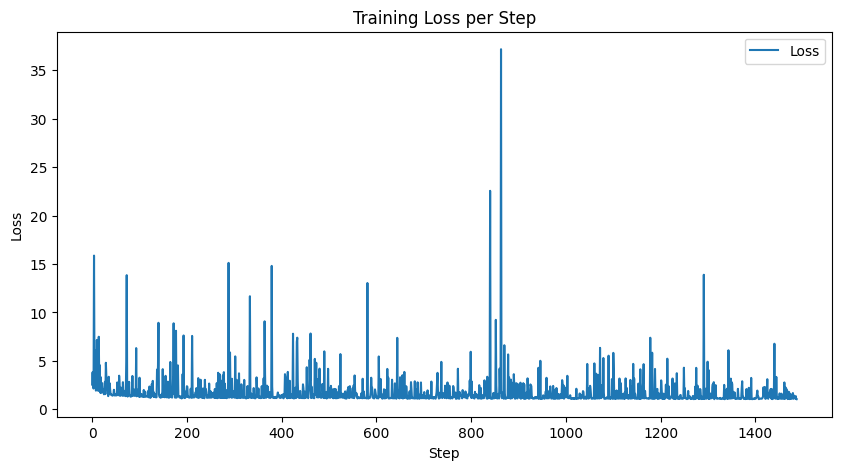

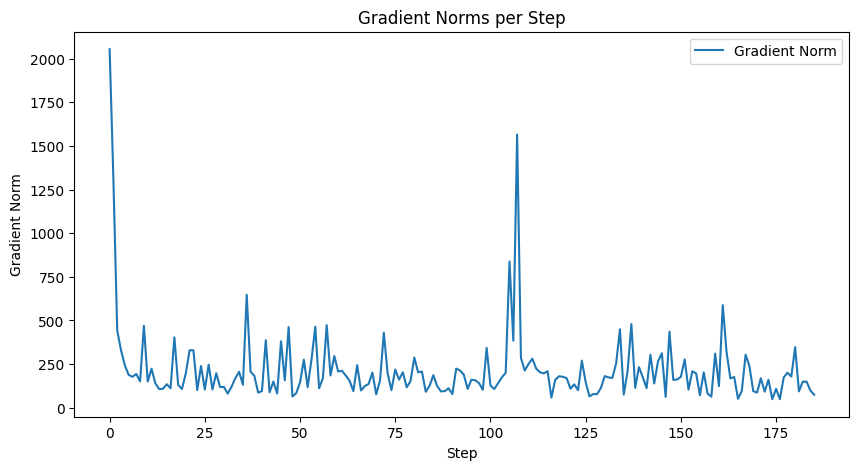

In [20]:
import matplotlib.pyplot as plt

# Load saved data
data = torch.load("training_metrics.pth")
losses = data["losses"]
gradient_norms = data["gradient_norms"]

# Move gradient norms to CPU if they are GPU tensors
gradient_norms = [g.cpu().item() if isinstance(g, torch.Tensor) else g for g in gradient_norms]

# outlier_step = 4
# losses[outlier_step] = (losses[outlier_step - 1] + losses[outlier_step + 1]) / 2

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss per Step')
plt.legend()
plt.show()

# Plot Gradient Norms
plt.figure(figsize=(10, 5))
plt.plot(gradient_norms, label='Gradient Norm')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms per Step')
plt.legend()
plt.show()


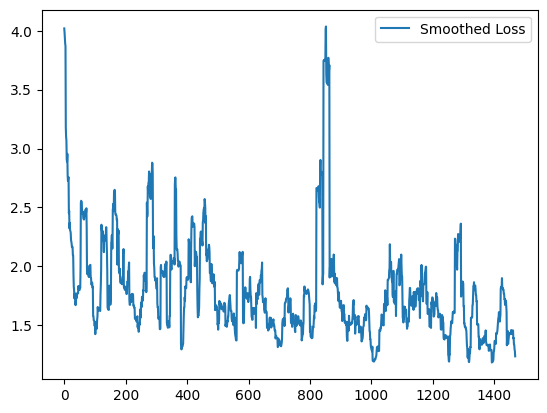

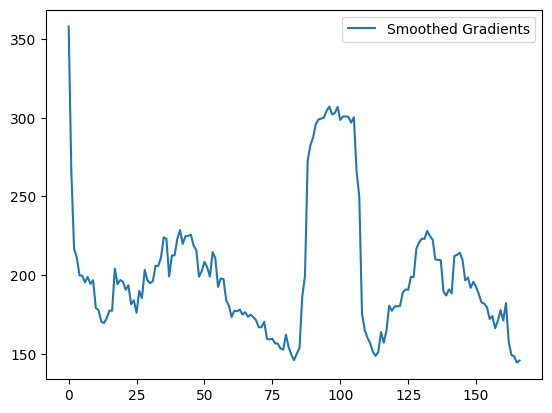

In [21]:
import numpy as np

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(losses, window_size=20)
smoothed_gradients = moving_average(gradient_norms, window_size=20)

# Plot smoothed values
plt.plot(smoothed_losses, label='Smoothed Loss')
plt.legend()
plt.show()

plt.plot(smoothed_gradients, label='Smoothed Gradients')
plt.legend()
plt.show()
